#### Creating a Machine Learning Model to predcit the event based on Φ-OTDR readings

We import the required libraries wherever and whenever required as per usage

In [1]:
import pandas as pd
df = pd.read_csv("images2.csv", names=["file_path","target"])
print(df.describe)


<bound method NDFrame.describe of                           file_path  target
0        ../trainData/drop/5491.jpg       0
1        ../trainData/drop/2712.jpg       0
2        ../trainData/drop/1075.jpg       0
3        ../trainData/drop/1237.jpg       0
4        ../trainData/drop/2854.jpg       0
...                             ...     ...
20995  ../trainData/qiaoji/2754.jpg       4
20996  ../trainData/qiaoji/3925.jpg       4
20997  ../trainData/qiaoji/4501.jpg       4
20998   ../trainData/qiaoji/252.jpg       4
20999  ../trainData/qiaoji/2526.jpg       4

[21000 rows x 2 columns]>


In [2]:
import numpy as np
from PIL import Image
from PIL import ImageFilter

from skimage.filters import prewitt_h,prewitt_v

Extracting basic features such as mean, std, corr and zero crossings

In [3]:
def img_mean(npa):  return np.mean(npa)

def img_std(npa):   return np.std(npa)

def img_corr(image):
    img_med = image.filter(ImageFilter.MedianFilter(size = 3))
    return np.corrcoef(image,img_med).mean()

def img_zcrs(npa):
    zcr = np.mean(npa, axis = 0) - npa.mean().mean()
    zero_crossings = np.where(np.diff(np.signbit(zcr)))[0]
    return len(zero_crossings)

def img_skew(npa):  return pd.DataFrame(npa).skew().mean()

def img_kurt(npa):  return pd.DataFrame(npa).kurtosis().mean()

def img_ver_edge(npa): return prewitt_v(npa).mean()

def img_hor_edge(npa): return prewitt_h(npa).mean()

Extracting the features such as number of data points in certain frequency ranges

In [4]:
def freq_ranges(npa):
    col = np.mean(npa, axis = 0)
    bt_0_50 = ((50>col) & (col>=0)).sum()
    bt_50_100 = ((100>col) & (col>=50)).sum()
    bt_100_150 = ((150>col) & (col>=100)).sum()
    ab_150 = (col>=150).sum()
    return bt_0_50, bt_50_100, bt_100_150, ab_150

def stren(npa): 
    temperory=freq_ranges(npa)
    strn=temperory[2]+temperory[3]
    return strn
    
def event(npa):
    zcr = np.mean(npa, axis = 0) - 100
    ev = len(np.where(np.diff(np.signbit(zcr)))[0])
    return ev

def img_stren(npa):

    if event(npa)==0:
        return 0
    else:
        val=2*stren(npa)/event(npa)
        return val

def spectral_energy(npa):
  mat=npa
  total=npa.sum()
  x=[]
  for i in range(4):
    count=0
    for j in range((len(mat)//4)*i,(len(mat)//4)*(i+1)):
      count+=sum(mat[j])
    x.append(count/total)
  return x[0],x[1],x[2],x[3]

Overall Extraction of features from the Images

In [5]:
dfm = pd.DataFrame( columns = ["mean", "std", "corr", "zcrs"] )

temp_df = pd.DataFrame( columns = ["skew", "kurtosis", "event_strength"] )

dup_df = pd.DataFrame( columns = ["edge_v", "edge_h"])

se_df = pd.DataFrame( columns = ["x[0]", "x[1]", "x[2]", "x[3]" ])

for imgs in df.file_path:
    image = Image.open(imgs)
    npa = np.array(image)
    
    dfm.loc[len(dfm)] = [ img_mean(npa), img_std(npa),img_corr(image), img_zcrs(npa) ]
    temp_df.loc[len(temp_df)] = [ img_skew(npa), img_kurt(npa), img_stren(npa)]
    dup_df.loc[len(dup_df)] = [img_ver_edge(npa), img_hor_edge(npa)]
    list = spectral_energy(npa)
    se_df.loc[len(se_df)] = list

dfm = pd.concat([dfm, temp_df], axis=1)
dfm = pd.concat([dfm, dup_df], axis =1)
dfm = pd.concat([dfm, se_df], axis=1)
dfm['target'] = df.target
dfm

,mean,std,corr,zcrs,skew,kurtosis,event_strength,edge_v,edge_h,x[0],x[1],x[2],x[3],target
0,25.765820,37.987719,0.641946,38.0,1.693545,4.235893,6.000000,-0.000297,0.001941,0.123381,0.288142,0.289867,0.298609,0
1,24.484570,40.607841,0.704699,18.0,1.683911,4.448071,4.000000,-0.000099,0.002135,0.124027,0.312687,0.314106,0.249180,0
2,25.393633,38.616103,0.636090,26.0,1.581144,3.511482,4.500000,-0.000152,0.003218,0.109798,0.266535,0.300964,0.322703,0
3,38.179883,52.298636,0.582311,36.0,1.662758,4.098637,5.142857,0.004713,0.004995,0.093242,0.236650,0.300809,0.369299,0
4,32.750898,47.866475,0.686309,24.0,1.601055,4.052781,3.000000,0.000144,0.003870,0.118435,0.258129,0.284491,0.338945,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,41.145313,49.929015,0.486868,36.0,1.436900,2.693499,2.857143,-0.002108,0.005676,0.094429,0.239033,0.285022,0.381517,4
20996,22.244258,40.136412,0.669736,10.0,1.632976,3.840018,2.000000,-0.000881,0.000666,0.141502,0.277087,0.334228,0.247183,4
20997,23.887070,32.084761,0.480300,18.0,1.674582,4.021697,1.200000,-0.000515,0.003082,0.115755,0.269571,0.313459,0.301216,4
20998,24.216875,36.220532,0.556774,6.0,1.662630,4.064199,2.500000,0.000119,0.002145,0.120955,0.290392,0.315316,0.273337,4


In [6]:
dfm.to_csv("ML_Features.csv")

We split the dataframe into the required features and target to train the model

In [7]:
X = dfm.drop('target',axis='columns')
y = dfm.target

from sklearn.preprocessing we import StandardScaler to remove the mean and scales each feature/variable to unit variance


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.20061701,  0.10082043,  1.44455375, ...,  0.44499414,
        -0.44067398, -0.18257587],
       [-0.28937809,  0.26485498,  1.84970224, ...,  0.99050104,
         0.39962908, -0.74755305],
       [-0.22640102,  0.14016085,  1.40674595, ..., -0.0352248 ,
        -0.05596038,  0.09282124],
       ...,
       [-0.33077106, -0.26873829,  0.40092621, ...,  0.03225498,
         0.37721028, -0.15278363],
       [-0.3079232 , -0.00981549,  0.89466378, ...,  0.49499257,
         0.44160167, -0.47143098],
       [ 1.63031299,  1.34855951, -0.34311493, ..., -1.00232305,
        -0.72361861,  0.99350207]])

In [9]:
from prettytable import PrettyTable
tab = PrettyTable()
tab.title = 'ML Model Scores with different splits'
tab.field_names = ['Split Ratio', 'KNNClassfier']

We use train_test_split to split the data for training the model and for testing the model,\
we can give paramaters such as test_size to determine how much of the data is given to testing and training, \
then import the required model from respective library and create a model

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

splits = [0.3]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = split, random_state = 40)

    model_knn = KNeighborsClassifier(n_neighbors=12)
    model_knn.fit(X_train, y_train)
    #knnscore = model_knn.score(X_test, y_test)
    scoresknn = cross_val_score(KNeighborsClassifier(), X_test, y_test, cv=5)
    scoresknn = scoresknn.mean()

    tab.add_row([f"Split: {split}", scoresknn])

In [11]:
from sklearn.model_selection import GridSearchCV


knn = KNeighborsClassifier()
k_range = [i for i in range(1,31)]
param_grid = dict(n_neighbors=k_range)
  
# defining parameter range
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=1)
  
# fitting the model for grid search
grid_search=grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [12]:
grid.cv_results_

{'mean_fit_time': array([0.09881473, 0.08895016, 0.09731913, 0.09060154, 0.09305835,
        0.08658895, 0.0907443 , 0.09310908, 0.09273505, 0.07584534,
        0.08731503, 0.07114725, 0.08157592, 0.08375349, 0.08156261,
        0.09514108, 0.08962579, 0.08155389, 0.09369144, 0.06707001,
        0.04891782, 0.09658628, 0.12459111, 0.12828035, 0.08077908,
        0.08690872, 0.08080263, 0.09576321, 0.093151  , 0.09238477]),
 'std_fit_time': array([0.02409419, 0.01190949, 0.00510038, 0.01271734, 0.01158377,
        0.01501548, 0.00425716, 0.00296049, 0.00246642, 0.01320921,
        0.01376805, 0.01594747, 0.01929396, 0.01252897, 0.01266689,
        0.00788408, 0.01055962, 0.00988156, 0.00113511, 0.02412557,
        0.00429909, 0.02606737, 0.01558872, 0.01245963, 0.01647412,
        0.0124253 , 0.01852716, 0.00577151, 0.002481  , 0.01001431]),
 'mean_score_time': array([0.59044347, 0.62337914, 0.64968433, 0.65008616, 0.68789582,
        0.68894968, 0.73787985, 0.76120553, 0.752773  , 0.73

In [13]:
dftest = pd.DataFrame(grid.cv_results_)
dftest

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.098815,0.024094,0.590443,0.098675,1,{'n_neighbors': 1},0.744558,0.738776,0.756463,0.744558,0.761565,0.749184,0.008455,29
1,0.088950,0.011909,0.623379,0.021041,2,{'n_neighbors': 2},0.730952,0.718027,0.737755,0.734014,0.750340,0.734218,0.010443,30
2,0.097319,0.005100,0.649684,0.039353,3,{'n_neighbors': 3},0.775170,0.766667,0.773469,0.776190,0.789456,0.776190,0.007418,27
3,0.090602,0.012717,0.650086,0.030985,4,{'n_neighbors': 4},0.769728,0.761905,0.771429,0.771769,0.796259,0.774218,0.011587,28
4,0.093058,0.011584,0.687896,0.067433,5,{'n_neighbors': 5},0.783333,0.783673,0.790816,0.792177,0.806463,0.791293,0.008397,25
5,0.086589,0.015015,0.688950,0.040419,6,{'n_neighbors': 6},0.780272,0.784014,0.790476,0.785714,0.803061,0.788707,0.007891,26
6,0.090744,0.004257,0.737880,0.038239,7,{'n_neighbors': 7},0.783673,0.790476,0.794558,0.790476,0.803061,0.792449,0.006354,24
7,0.093109,0.002960,0.761206,0.091418,8,{'n_neighbors': 8},0.785714,0.789796,0.794898,0.791837,0.809524,0.794354,0.008151,21
8,0.092735,0.002466,0.752773,0.066982,9,{'n_neighbors': 9},0.790816,0.799660,0.798980,0.790476,0.815986,0.799184,0.009257,2
9,0.075845,0.013209,0.738409,0.096738,10,{'n_neighbors': 10},0.788095,0.799660,0.800680,0.785714,0.815306,0.797891,0.010568,6


In [14]:
file_data='knc_0.3.csv'
dftest.to_csv(file_data)

In [15]:
print(grid_search.best_params_)

{'n_neighbors': 15}


#List Hyperparameters that we want to tune.
from sklearn.model_selection import GridSearchCV

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Printing all the scores of the Models

C = []
for i in range(30,35):
    C.append(i)

from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('rbf','poly'), 'C':C}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train,y_train)
GridSearchCV(estimator=SVC(),
             param_grid={'C':C, 'kernel': ('rbf','poly')})
sorted(clf.cv_results_)

dftest = pd.DataFrame(clf.cv_results_)
dftest

In [16]:
#file_data='file_data_new.csv'
#dftest.to_csv(file_data)

In [17]:
print(tab)

+----------------------------------------+
| ML Model Scores with different splits  |
+---------------+------------------------+
|  Split Ratio  |      KNNClassfier      |
+---------------+------------------------+
|   Split: 0.3  |   0.7676190476190475   |
+---------------+------------------------+


We use Seaborn library to plot the confusion matrix to check the truth matrix i.e, \
how many correct predictions are there and for how many the model was confused to predict

We use the last model to plot the confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

y_pred_knn = model_knn.predict(X_test)

cm_knn = confusion_matrix(y_test, y_pred_knn)


In [19]:
from sklearn import metrics

print(metrics.confusion_matrix(y_test, y_pred_knn))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_test, y_pred_knn, digits=3))

[[ 919   27    0    2  301]
 [  26  992  165   30   72]
 [   0  213 1011   17   11]
 [   0  115   66 1046   23]
 [ 143   46    1    3 1071]]
              precision    recall  f1-score   support

           0      0.845     0.736     0.786      1249
           1      0.712     0.772     0.741      1285
           2      0.813     0.808     0.810      1252
           3      0.953     0.837     0.891      1250
           4      0.725     0.847     0.781      1264

    accuracy                          0.800      6300
   macro avg      0.809     0.800     0.802      6300
weighted avg      0.809     0.800     0.802      6300



Text(0.5, 1.0, 'KNNClassifier')

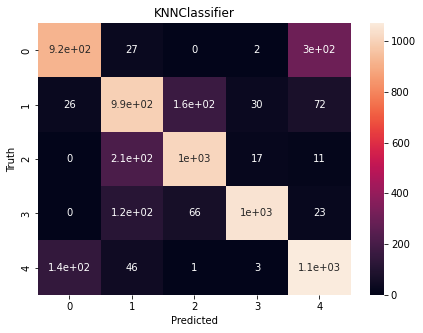

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(7,5))

sn.heatmap(cm_knn, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('KNNClassifier')